# Approximate Bayesian Computation


In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import corner 

# Example 0
Let's return to the example from a few weeks ago

> Imagine a hypothetical simplistic example, where we point our telescope to observe the light from a single star with true flux $F_{\rm true}$, which remains constant with time. We will ignore any systematic errors. We perform $N$ measurements with our telescope, where the $i^{\rm th}$ measurement report an observed flux $F_i$ with uncertainty/error $e_i$.

Lets generate a synthetic observation

In [4]:
F_true = 1000
F_obs = np.random.poisson(lam=F_true)

Let's write down the a simulation of the data generation process. In this case this is trivial because we know exactly the data generation process

In [5]:
def simulation(F_true): 
    return np.random.poisson(lam=F_true)

ABC involves repeating two steps
1. sample the prior: $\theta'\sim p(\theta)$
2. run simulation: $\mathcal{D}' \sim F(\theta')$

For our prior, lets use
$$p(\theta) = \mathcal{N}(1002, 4)$$

In [7]:
def sample_prior(): 
    # sample prior
    return 1002. + 4. * np.random.normal()

In [8]:
Nsample = 100000

samples = np.zeros((Nsample, 2))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.array([theta_p, data_p])

Text(0, 0.5, '$\\mathcal{D}$')

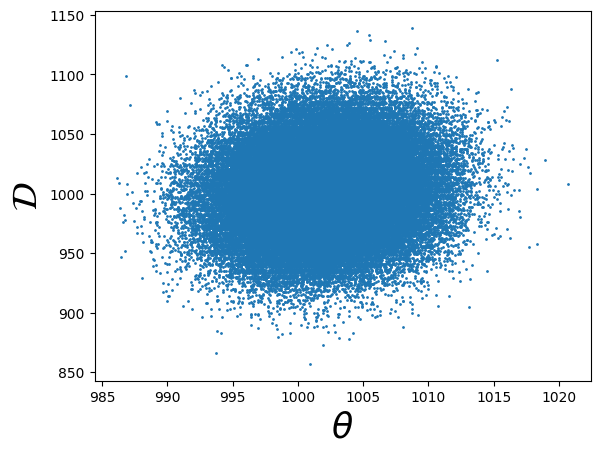

In [22]:
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.xlabel(r'$\theta$', fontsize=25)
plt.ylabel(r'$\mathcal{D}$', fontsize=25)

Now we have a samples bunch of $\{(\theta', \mathcal{D}')\}$ that are drawn from the joint distribution $p(\theta, \mathcal{D})$. 

To obtain the posterior from this, ABC approximates: 
$$p(\theta\,|\,\mathcal{D}_{\rm obs}) \approx p(\theta\,|\,\mathcal{D} \approx \mathcal{D}_{\rm obs})$$

In [15]:
close_enough = np.abs(samples[:,1] - F_obs) < 1
print('%i have D \approx D_obs' % np.sum(close_enough))

1273 have D pprox D_obs


Text(0, 0.5, '$\\mathcal{D}$')

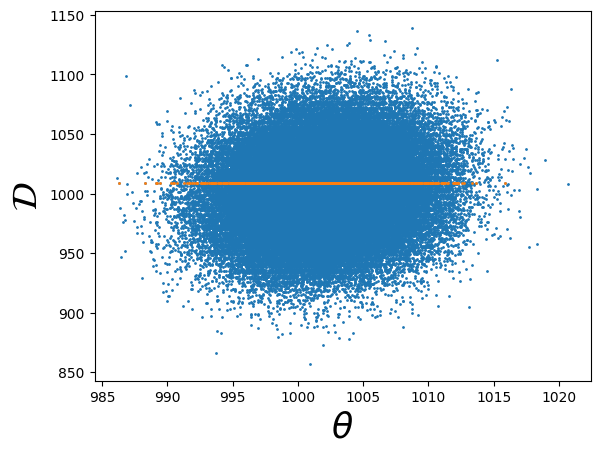

In [23]:
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.scatter(samples[:,0][close_enough], samples[:,1][close_enough], s=1, c='C1')
plt.xlabel(r'$\theta$', fontsize=25)
plt.ylabel(r'$\mathcal{D}$', fontsize=25)

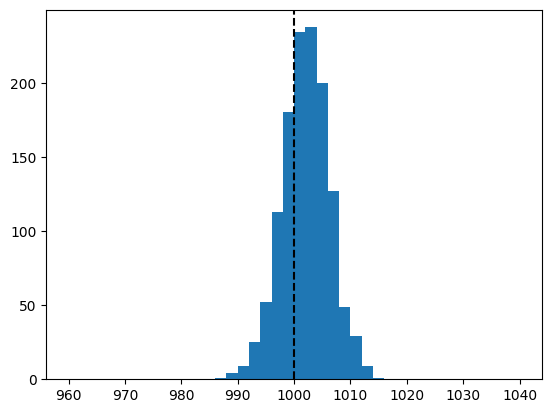

In [19]:
plt.hist(samples[:,0][close_enough], range=(960, 1040), bins=40)
plt.axvline(F_true, color='k', linestyle='--')

# Example 1
Now that was a very simple 1D example. Lets consider a slightly more interesting example of fitting a line to some data. Here's the same data and setup from the MCMC example: 

In [30]:
a_true, b_true = 0, 1.75
x = np.array([1,1.5,2,2.5])
y = np.array([1.87640523, 2.59001572, 3.4978738 , 4.47408932])
yerr = 0.1

<ErrorbarContainer object of 3 artists>

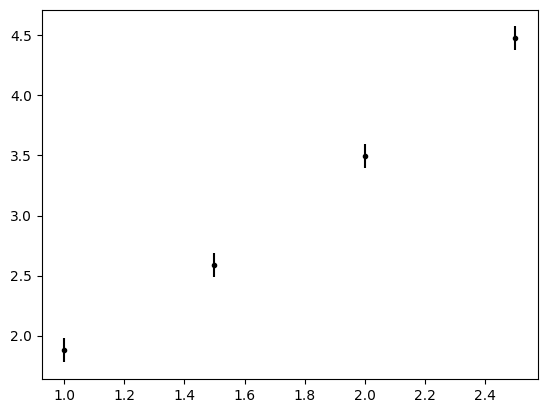

In [29]:
plt.errorbar(x, y, yerr=yerr, fmt='.k')

In [58]:
def simulation(theta): 
    a, b = theta
    noise = yerr * np.random.normal(size=len(x))
    return a + b * x + noise

def sample_prior(): 
    # sample a and b from uniform prior
    _a = -0.5 + np.random.uniform() 
    _b = 10*np.random.uniform()
    return [_a, _b]

In [79]:
Nsample = 500000

samples = np.zeros((Nsample, 6))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.concatenate([theta_p, data_p])

Now this is harder to visualize since $\theta$ is 2D and $\mathcal{D}$ is 4D. Now $p(\theta, \mathcal{D})$ is a 6D distribution. Nevertheless, the procedure for ABC remains the same: 
1. keep only samples with $\mathcal{D} \approx \mathcal{D}_{\rm obs}$
2. examine the distribution of $\theta$

Since $\mathcal{D}$ is 4D, we will use $\rho(\mathcal{D}, \mathcal{D}') < \epsilon$ for (1)

In [81]:
rho = np.sqrt(np.sum((samples[:,2:] - y[None, :])**2, axis=1))

In [86]:
epsilon = 0.5
print('reject %f percent of simulations' % (100.*(1-np.mean(rho < epsilon))))

reject 97.814400 percent of simulations


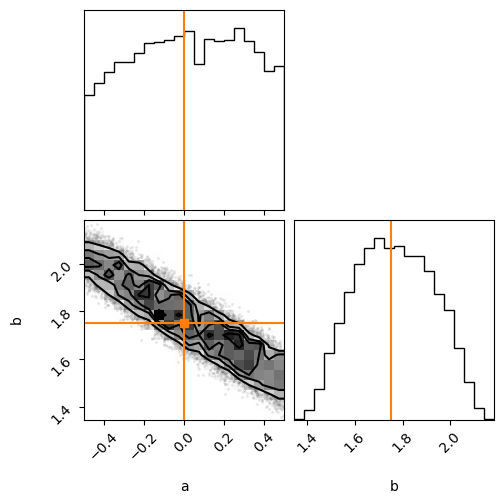

In [78]:
fig = corner.corner(samples[:,:2][rho < epsilon], labels=['a', 'b'])
corner.overplot_lines(fig, [a_true, b_true], color="C1")
corner.overplot_points(fig, np.array([a_true, b_true])[None], marker="s", color="C1")

Now you may notice that the posterior here is significantly broader than the posterior from the MCMC example. That's the "approximate" part of ABC and a consequence of the fact that we relax the $\mathcal{D} = \mathcal{D}'$ criterion to $\rho(\mathcal{D}, \mathcal{D}') < \epsilon$. Now if we reduce $\epsilon$, we'll get closer to the true posterior

In [85]:
epsilon = 0.2
print('reject %f percent of simulations' % (100.*(1-np.mean(rho < epsilon))))

reject 99.809800 percent of simulations


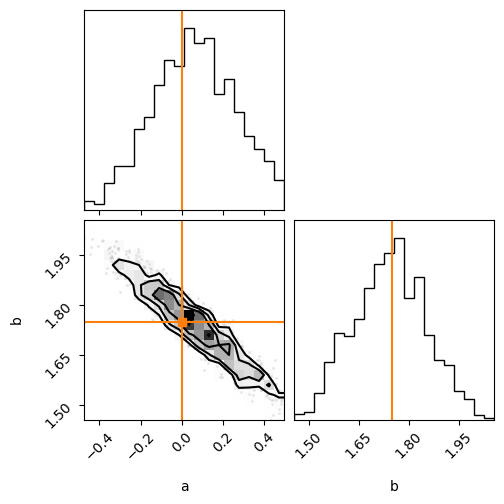

In [83]:
fig = corner.corner(samples[:,:2][rho < epsilon], labels=['a', 'b'])
corner.overplot_lines(fig, [a_true, b_true], color="C1")
corner.overplot_points(fig, np.array([a_true, b_true])[None], marker="s", color="C1")

But there are fewer samples and the posterior estimate is noisier. As you decrease $\epsilon$, you get closer to the true posterior but you also need to sample $p(\theta, \mathcal{D})$ more times.